In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 80% !important; }</style>"))

In [3]:
import sys
import time
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import colors

In [4]:
myColors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
            '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
            '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
            '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
            '#307D7E', '#000000', "#DDEFFF", "#000035", "#7B4F4B", 
            "#A1C299", "#300018", "#C2FF99", "#0AA6D8", "#013349", 
            "#00846F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", 
            "#1E6E00", "#DFFB71", "#868E7E", "#513A01", "#CCAA35"]

colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [5]:
sys.path.append("../functions")
from SMaSH_functions import SMaSH_functions

sf = SMaSH_functions()

 * Initialising ...



In [6]:
sys.path.append("/home/ubuntu/Taneda/Functions")
from scRNA_functions import scRNA_functions

fc = scRNA_functions()

 * Initialising ...


# Loading annData object

In [7]:
obj = sc.datasets.paul15()

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, copying.


In [8]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

3451 genes across 2730 cells


In [9]:
dict_annotation = {}

dict_annotation['1Ery']='Ery'
dict_annotation['2Ery']='Ery'
dict_annotation['3Ery']='Ery'
dict_annotation['4Ery']='Ery'
dict_annotation['5Ery']='Ery'
dict_annotation['6Ery']='Ery'
dict_annotation['7MEP']='MEP'
dict_annotation['8Mk']='Mk'
dict_annotation['9GMP']='GMP'
dict_annotation['10GMP']='GMP'
dict_annotation['11DC']='DC'
dict_annotation['12Baso']='Baso'
dict_annotation['13Baso']='Baso'
dict_annotation['14Mo']='Mo'
dict_annotation['15Mo']='Mo'
dict_annotation['16Neu']='Neu'
dict_annotation['17Neu']='Neu'
dict_annotation['18Eos']='Eos'
dict_annotation['19Lymph']='Lymph'

fc.mergeClusters(obj, newName='annotation', labels=dict_annotation, cluster='paul15_clusters', verbose=True)

obj.obs['annotation'] = obj.obs['annotation'].astype("category")

 * Merging groups and renaming (column annotation) ... 
 	* Old label 1Ery - new label Ery
 	* Old label 2Ery - new label Ery
 	* Old label 3Ery - new label Ery
 	* Old label 4Ery - new label Ery
 	* Old label 5Ery - new label Ery
 	* Old label 6Ery - new label Ery
 	* Old label 7MEP - new label MEP
 	* Old label 8Mk - new label Mk
 	* Old label 9GMP - new label GMP
 	* Old label 10GMP - new label GMP
 	* Old label 11DC - new label DC
 	* Old label 12Baso - new label Baso
 	* Old label 13Baso - new label Baso
 	* Old label 14Mo - new label Mo
 	* Old label 15Mo - new label Mo
 	* Old label 16Neu - new label Neu
 	* Old label 17Neu - new label Neu
 	* Old label 18Eos - new label Eos
 	* Old label 19Lymph - new label Lymph
 *  Groups merged


#### Data preparation

In [10]:
sf.data_preparation(obj)

#### Removing general genes

In [11]:
s1 = time.time()

In [12]:
obj = sf.remove_general_genes(obj)

#### Removing house-keeping genes

http://www.housekeeping.unicamp.br/?homePageGlobal

In [13]:
obj = sf.remove_housekeepingenes(obj, path="../data/house_keeping_genes_Mouse_bone_marrow.txt")
obj = sf.remove_housekeepingenes(obj, path="../data/house_keeping_genes_Mouse_HSC.txt")

#### Removing genes expressed in less than 30% within groups

In [14]:
annotation = sf.remove_features_pct(obj, group_by="annotation", pct=0.3)

#### Removing genes expressed in more than 50% in a given group where genes are expressed for more 75% within a given group

In [15]:
obj = sf.remove_features_pct_2groups(obj, group_by="annotation", pct1=0.75, pct2=0.5)

#### Revert PCA

In [16]:
obj = sf.scale_filter_features(obj, n_components=None, filter_expression=True)

Fraction passing PCA: 0.9848634419216847


#### ensemble_learning

In [17]:
s2 = time.time()

Running with XGBoost (as of now, class_weight not implemented)
[16:54:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<Figure size 432x288 with 0 Axes>

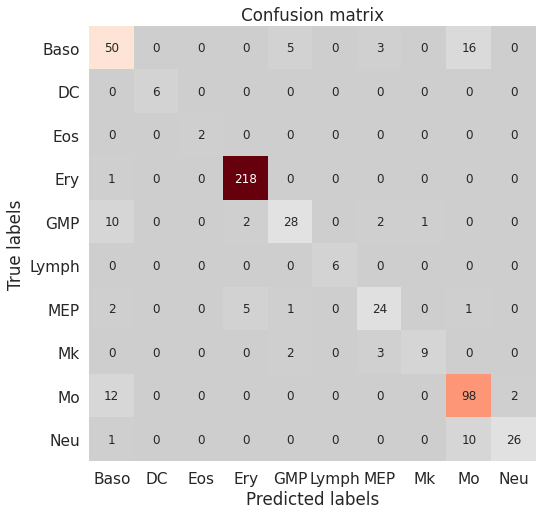

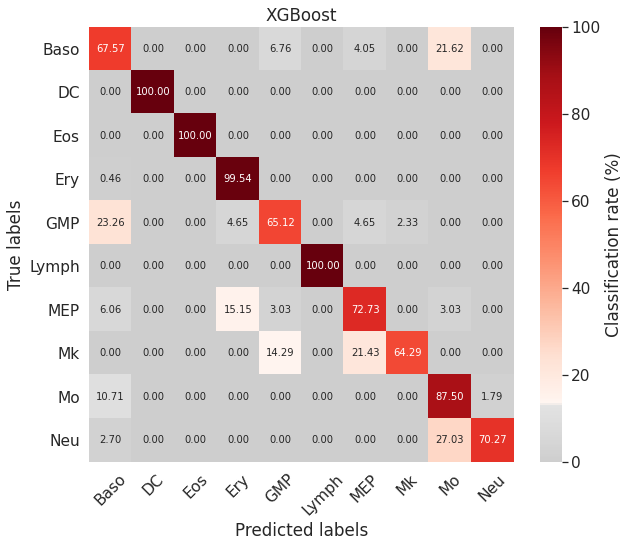

Accuracy: 0.8553113553113553: Misclassification: 0.14468864468864473
              precision    recall  f1-score   support

        Baso       0.66      0.68      0.67        74
          DC       1.00      1.00      1.00         6
         Eos       1.00      1.00      1.00         2
         Ery       0.97      1.00      0.98       219
         GMP       0.78      0.65      0.71        43
       Lymph       1.00      1.00      1.00         6
         MEP       0.75      0.73      0.74        33
          Mk       0.90      0.64      0.75        14
          Mo       0.78      0.88      0.83       112
         Neu       0.93      0.70      0.80        37

    accuracy                           0.86       546
   macro avg       0.88      0.83      0.85       546
weighted avg       0.86      0.86      0.85       546



In [18]:
clf = sf.ensemble_learning(obj, group_by="annotation", classifier="XGBoost", balance=True, verbose=True)

#### gini_importance

In [19]:
selectedGenes, selectedGenes_dict = sf.gini_importance(obj, clf, group_by="annotation", verbose=True, restrict_top=("local", 20))

In [20]:
e2 = time.time()

#### Classifiers

<Figure size 432x288 with 0 Axes>

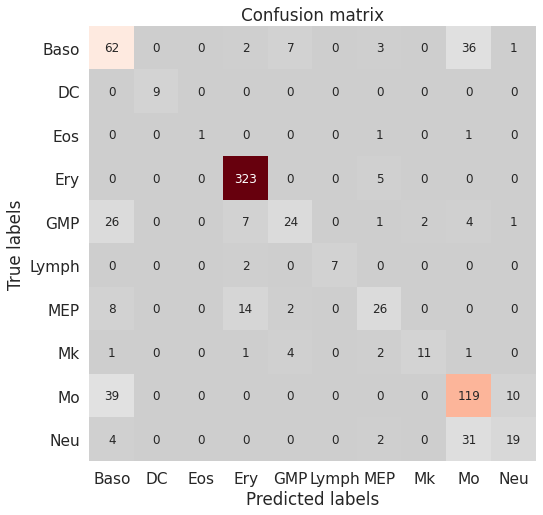

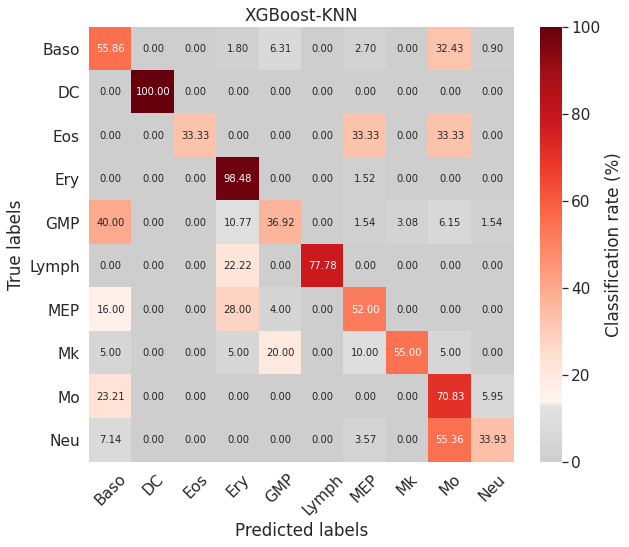

Accuracy: 0.7338217338217338: Misclassification: 0.26617826617826623
              precision    recall  f1-score   support

        Baso       0.44      0.56      0.49       111
          DC       1.00      1.00      1.00         9
         Eos       1.00      0.33      0.50         3
         Ery       0.93      0.98      0.95       328
         GMP       0.65      0.37      0.47        65
       Lymph       1.00      0.78      0.88         9
         MEP       0.65      0.52      0.58        50
          Mk       0.85      0.55      0.67        20
          Mo       0.62      0.71      0.66       168
         Neu       0.61      0.34      0.44        56

    accuracy                           0.73       819
   macro avg       0.77      0.61      0.66       819
weighted avg       0.74      0.73      0.73       819



In [21]:
sf.run_classifiers(obj, group_by="annotation", genes=selectedGenes, classifier="KNN", balance=True, title="XGBoost-KNN")

#### Sorting genes per cluster

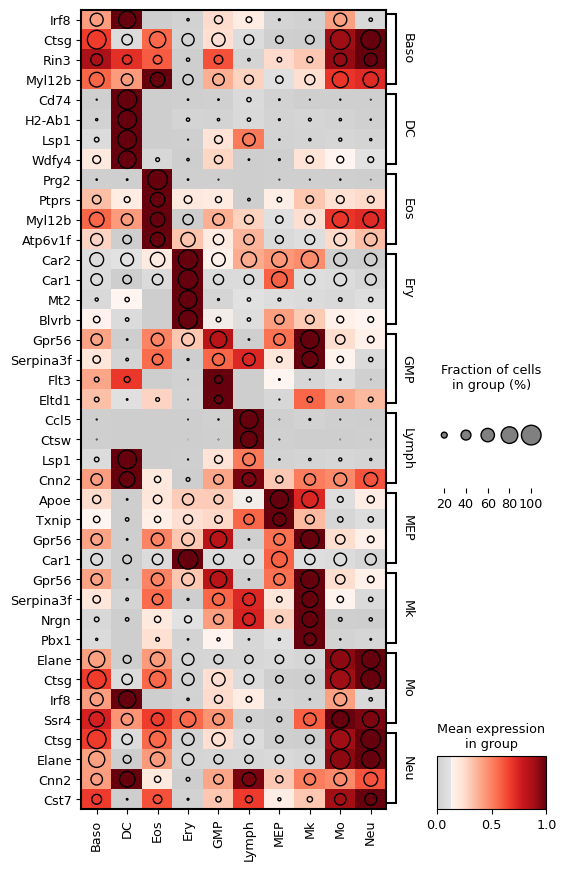

In [22]:
axs, selectedGenes_top_dict = sf.sort_and_plot(obj, selectedGenes, group_by="annotation", group_by2=None, top=4, figsize=(6,10))

In [23]:
e1 = time.time()

In [24]:
# axs.savefig("Figures/XGBoost_top5_perGroup.pdf")

# Elapsed time

In [25]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

2993 genes across 2730 cells


In [26]:
print('Elapsed time (s): ', e1-s1)

Elapsed time (s):  40.39845108985901


In [27]:
print('Elapsed time (s): ', e2-s2)

Elapsed time (s):  25.686725854873657
